In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
import xgboost as xgb
import HomeMade as hm
import pandas as pd
import importlib

In [2]:
ML1 = "v0_chi2 v0_px1 v0_phi1 v0_py1 v0_py v0_py2 v0_phi2 v0_px2 v0_px".split(" ")
ML2 = "cosTheta a0xy a0 v0_y v0_x v0_rxyErr v0_rxy v0_z pv0_z pv0_y ntrk_pv0 pv0_x".split(" ")

In [3]:
N = None

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2+["v0_ks_massErr"], entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_test_slice = int(len(data)*0.8)
train_data = data[:train_test_slice]
test_data = data[train_test_slice:]

# path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
# file = uproot.open(path)
# mc = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2+['trueKs'], entrystop = N)

In [4]:
test_data.index

Int64Index([4704896, 4704899, 4704900, 4704901, 4704902, 4704904, 4704908,
            4704911, 4704915, 4704916,
            ...
            5881524, 5881525, 5881526, 5881529, 5881530, 5881533, 5881536,
            5881539, 5881541, 5881542],
           dtype='int64', name='entry', length=479510)

In [209]:
# hm = importlib.reload(hm)
# vals, binc, binw = hm.hist(data.v0_ks_mass,bins=200)
# dd = hm.fit_mass2(binc,vals,np.sqrt(vals))

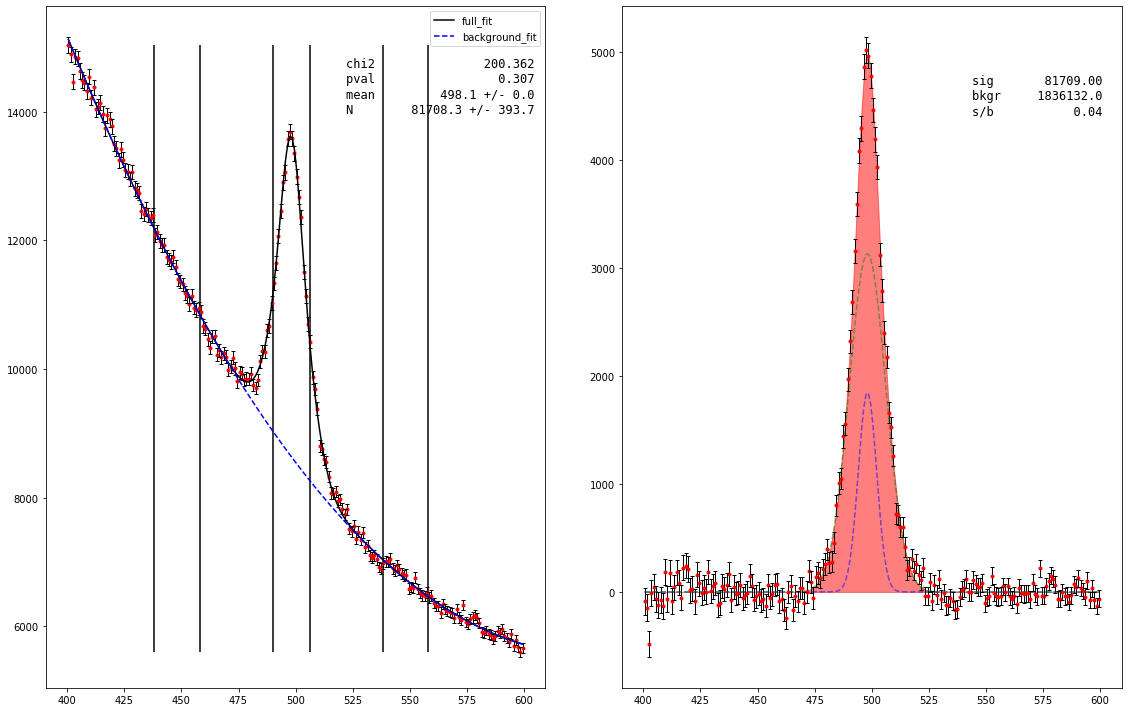

In [5]:
hm = importlib.reload(hm)
train_data = hm.assign_pseudolabels(train_data,bins=200)

In [8]:
cla = xgb.XGBClassifier()
cla.fit(train_data[ML1+ML2],y=train_data.y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

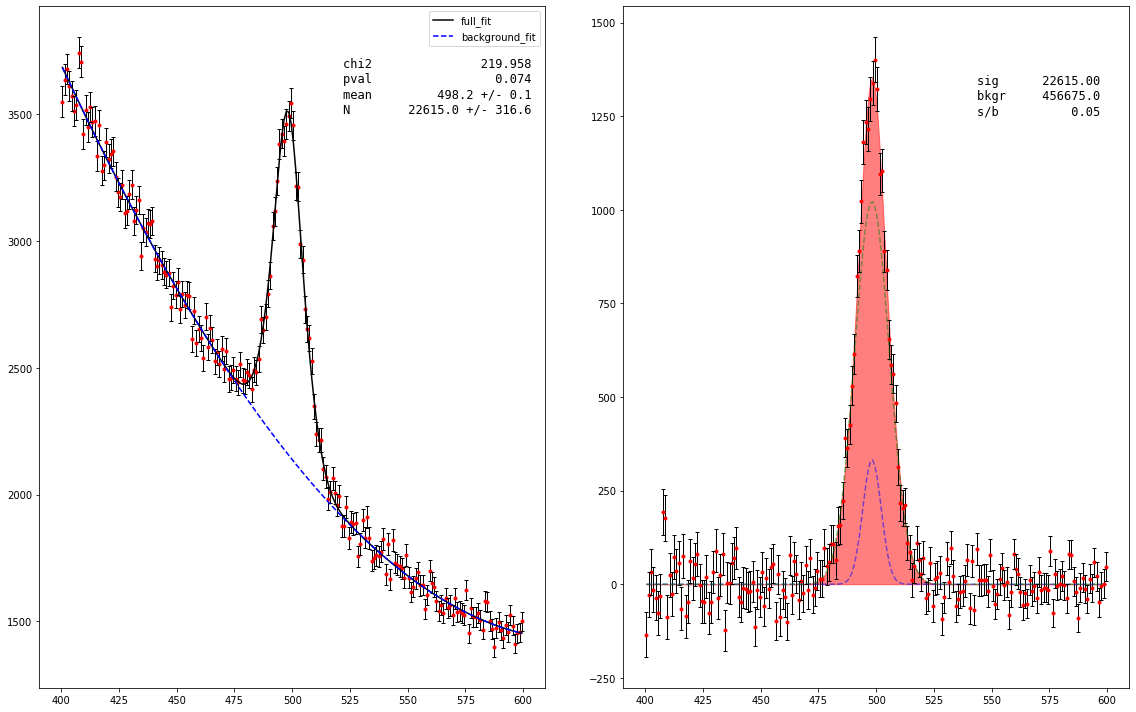

In [201]:
# fig, ax = plt.subplots()
hm = importlib.reload(hm)
vals, binc, binw = hm.hist(test_data.v0_ks_mass,bins=200)
d = hm.fit_mass2(binc,vals,np.sqrt(vals))

In [189]:
p = cla.predict_proba(test_data[ML1+ML2])[:,0]

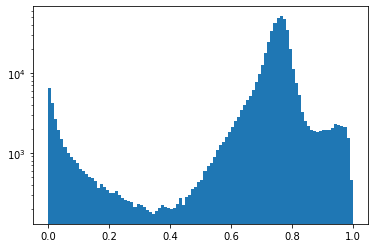

In [190]:
from scipy.special import logit
# plt.hist(logit(p),bins=100);
plt.hist(p,bins=100);
plt.yscale('log')

(475, 550)

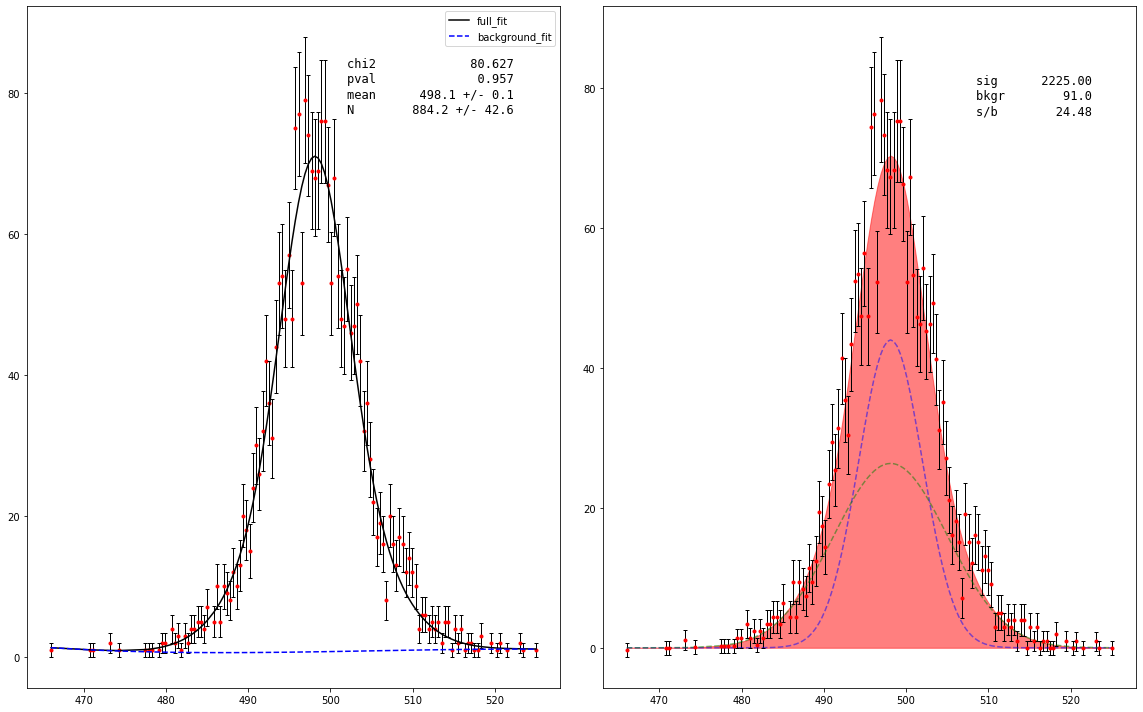

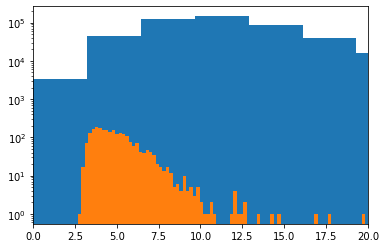

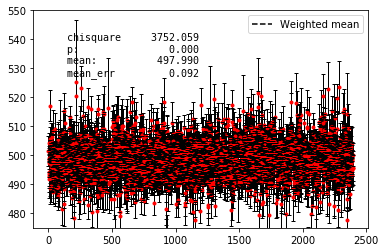

In [196]:
hm = importlib.reload(hm)
p_mask = p<= np.quantile(p,0.005)
mass_quantile = np.quantile(test_data.v0_ks_mass[p_mask],(0,1))
mask_mass = (p_mask)&(test_data.v0_ks_mass>mass_quantile[0])&(test_data.v0_ks_mass<mass_quantile[1])#&(test_data.v0_ks_massErr <14)
vals, binc, binw = hm.hist(test_data.v0_ks_mass[mask_mass],bins=150)

# fig, ax = plt.subplots()
# ax.hist(test_data.v0_ks_mass[p<=0.38],bins=100);
mask = vals >=1
D = hm.fit_mass2(binc[mask],vals[mask],np.sqrt(vals[mask]))

plt.figure()
plt.hist(test_data.v0_ks_massErr,bins=100);
plt.hist(test_data.v0_ks_massErr[mask_mass],bins=100);
plt.yscale('log')
plt.xlim(0,20)

hm = importlib.reload(hm)
fig, ax = plt.subplots()
hm.weighted_mean(test_data.v0_ks_mass[mask_mass],test_data.v0_ks_massErr[mask_mass],ax=ax)
# ax.set_ylim(400,700)
ax.set_ylim(475,550)

In [6]:
#Shuffle training data
train_data = train_data.sample(frac=1)

train_split = len(train_data)//2

print(train_data[:train_split].y.sum(),train_data[train_split:].y.sum())

67573.0 67513.0


In [7]:
cla1 = xgb.XGBClassifier()
cla2 = xgb.XGBClassifier()

cla1.fit(train_data[:train_split][ML1],y=train_data[:train_split].y)
cla2.fit(train_data[train_split:][ML2],y=train_data[train_split:].y)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [9]:
p = cla.predict_proba(test_data[ML1+ML2])[:,0]
p1 = cla1.predict_proba(test_data[ML1])[:,0]
p2 = cla2.predict_proba(test_data[ML2])[:,0]

In [19]:
df = pd.concat([test_data.v0_ks_mass,test_data.v0_ks_massErr,
          pd.Series(p1,name='ML1_data',index=test_data.index),
          pd.Series(p2,name='ML2_data',index=test_data.index),
          pd.Series(p,name='ML12_data',index=test_data.index)],axis=1)

In [22]:
# df.to_pickle('ks_predictions.dat')

In [216]:
sum((p1<=0.01)&(p2<=0.01))

0

No background valid minimum found!


(475, 550)

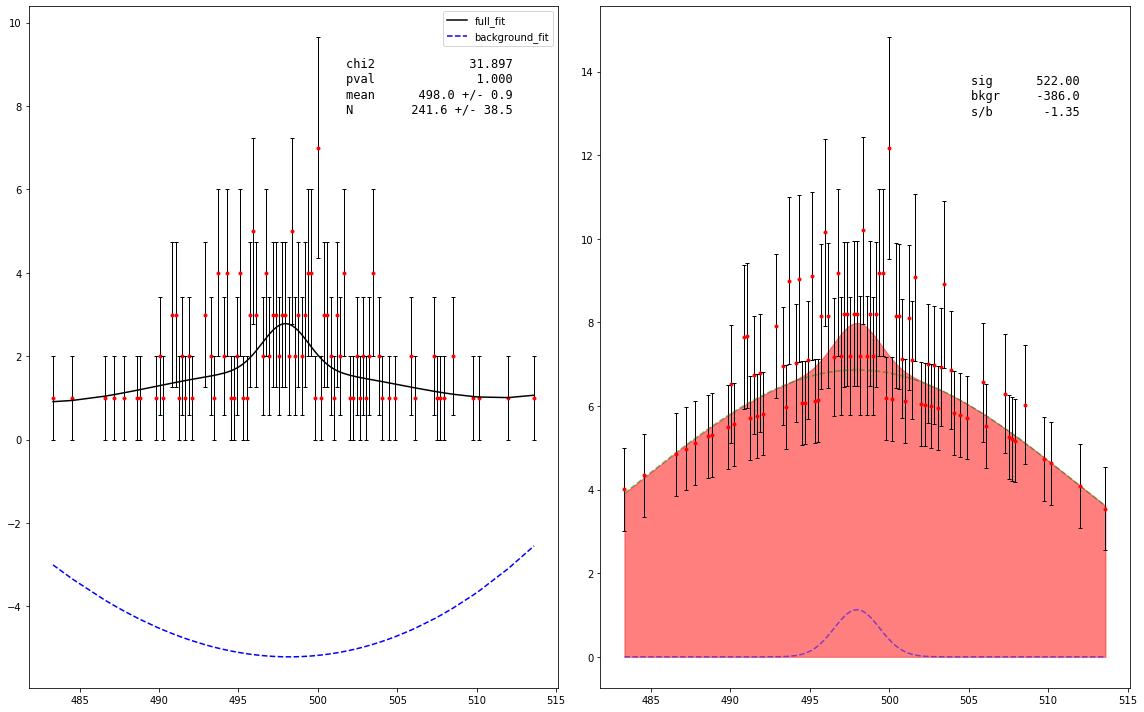

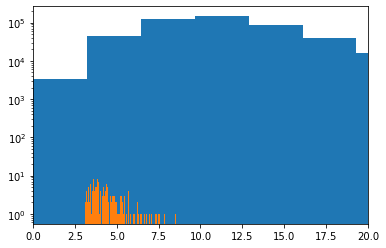

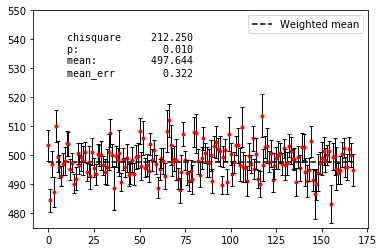

In [236]:
hm = importlib.reload(hm)
p_mask = (p1<=np.quantile(p1,0.006))&(p2<=np.quantile(p2,0.006))
mass_quantile = np.quantile(test_data.v0_ks_mass[p_mask],(0,1))
mask_mass = (p_mask)&(test_data.v0_ks_mass>=mass_quantile[0])&(test_data.v0_ks_mass<=mass_quantile[1])&(test_data.v0_ks_massErr <10)
vals, binc, binw = hm.hist(test_data.v0_ks_mass[mask_mass],bins=150)

# fig, ax = plt.subplots()
# ax.hist(test_data.v0_ks_mass[p<=0.38],bins=100);
mask = vals >=1
D = hm.fit_mass2(binc[mask],vals[mask],np.sqrt(vals[mask]))

plt.figure()
plt.hist(test_data.v0_ks_massErr,bins=100);
plt.hist(test_data.v0_ks_massErr[mask_mass],bins=100);
plt.yscale('log')
plt.xlim(0,20)

hm = importlib.reload(hm)
fig, ax = plt.subplots()
hm.weighted_mean(test_data.v0_ks_mass[mask_mass],test_data.v0_ks_massErr[mask_mass],ax=ax)
# ax.set_ylim(400,700)
ax.set_ylim(475,550)

In [234]:
ax.set(title=('Weighted mean of best K-short candidates'),
      xlabel=f'N candidates: {sum(mask_mass)}',
      ylabel='v0_ks_mass')
fig
# fig.savefig('K_short_mass_result.pdf')

In [235]:
sum(mask_mass), len(test_data)

(167, 479510)

Draw ROC curves in data using fits:

In [7]:
p1 = cla1.predict_proba(test_data[ML1])[:,0]

Completed fit with Chi2: 95.2, p-val: 0.361 and the total amount of signal 23149 +/- 293, background: 456362
Completed fit with Chi2: 96.2, p-val: 0.333 and the total amount of signal 16629 +/- 388, background: 453291
Completed fit with Chi2: 96.0, p-val: 0.339 and the total amount of signal 12092 +/- 398, background: 448238
Completed fit with Chi2: 96.5, p-val: 0.328 and the total amount of signal 8888 +/- 266, background: 441852
Completed fit with Chi2: 95.1, p-val: 0.364 and the total amount of signal 6668 +/- 276, background: 434482
Completed fit with Chi2: 111.9, p-val: 0.068 and the total amount of signal 4828 +/- 203, background: 426732
Completed fit with Chi2: 137.3, p-val: 0.001 and the total amount of signal 3450 +/- 84, background: 418520
Completed fit with Chi2: 180.1, p-val: 0.000 and the total amount of signal 2585 +/- 144, background: 409795
Completed fit with Chi2: 233.5, p-val: 0.000 and the total amount of signal 1849 +/- 26, background: 400941
No valid minimum found!

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 429.7, p-val: 0.000 and the total amount of signal 250 +/- 114, background: 354589
Completed fit with Chi2: 457.1, p-val: 0.000 and the total amount of signal 151 +/- 11, background: 345098
Completed fit with Chi2: 477.0, p-val: 0.000 and the total amount of signal 6 +/- 16, background: 335651
Completed fit with Chi2: 492.4, p-val: 0.000 and the total amount of signal 0 +/- 11, background: 326067
Completed fit with Chi2: 495.7, p-val: 0.000 and the total amount of signal 0 +/- 100, background: 316477
Completed fit with Chi2: 501.3, p-val: 0.000 and the total amount of signal 0 +/- 13, background: 306887
Completed fit with Chi2: 510.0, p-val: 0.000 and the total amount of signal 0 +/- 12, background: 297297
Completed fit with Chi2: 516.7, p-val: 0.000 and the total amount of signal 0 +/- 11, background: 287706
Completed fit with Chi2: 524.6, p-val: 0.000 and the total amount of signal 0 +/- 11, background: 278116
Completed fit with Chi2: 534.6, p-val: 0.000 and 

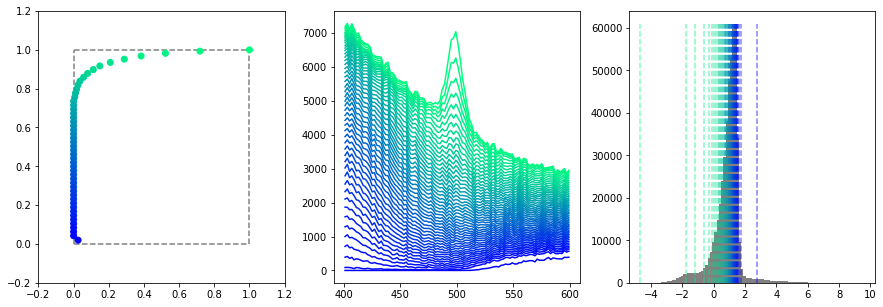

In [8]:
import importlib 
hm = importlib.reload(hm)

fig1, ax1 = plt.subplots(figsize = (15,5),ncols=3)

AUC1, cuts1 = hm.roc_curve_data(test_data.v0_ks_mass, p1,Npoints=50,ax_roc=ax1[0],ax_fits=ax1[1],ax_hist=ax1[2])

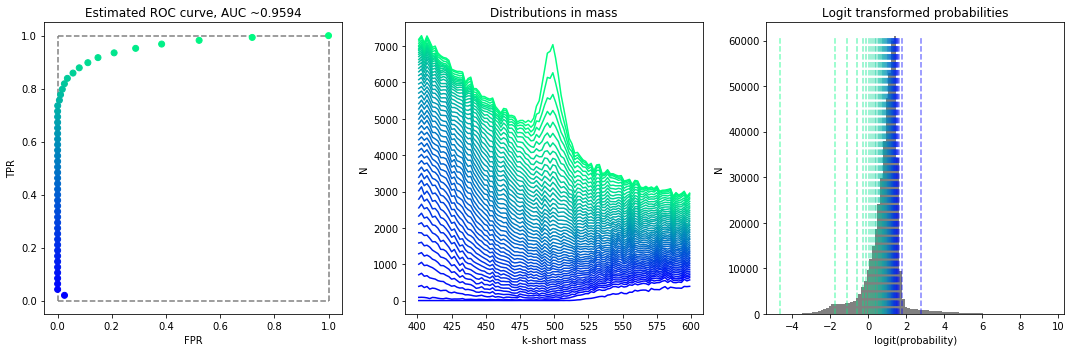

In [9]:
ax1[0].set(title=f'Estimated ROC curve, AUC ~{1+AUC1:.4f}', xlabel='FPR', ylabel='TPR',ylim=(-0.05,1.05),xlim=(-0.05,1.05))
ax1[1].set(title='Distributions in mass',xlabel='k-short mass', ylabel='N')
ax1[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig1.tight_layout()
fig1
# fig1.savefig('figures/ML1_roc_data.pdf')

In [10]:
p2 = cla2.predict_proba(test_data[ML2])[:,0]

Completed fit with Chi2: 95.2, p-val: 0.361 and the total amount of signal 23149 +/- 293, background: 456362
No valid minimum found!
Completed fit with Chi2: 95.2, p-val: 0.362 and the total amount of signal 13714 +/- 16852, background: 456207
Completed fit with Chi2: 97.5, p-val: 0.302 and the total amount of signal 5828 +/- 89, background: 454503
Completed fit with Chi2: 106.4, p-val: 0.129 and the total amount of signal 922 +/- 507, background: 449819
Completed fit with Chi2: 121.1, p-val: 0.019 and the total amount of signal 237 +/- 5, background: 440914
Completed fit with Chi2: 115.3, p-val: 0.043 and the total amount of signal 248 +/- 38, background: 431312
Completed fit with Chi2: 121.5, p-val: 0.018 and the total amount of signal 246 +/- 3, background: 421724
Completed fit with Chi2: 120.4, p-val: 0.021 and the total amount of signal 175 +/- 25, background: 412205
Completed fit with Chi2: 117.0, p-val: 0.035 and the total amount of signal 202 +/- 93, background: 402587
Complete

C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1741: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)
C:\Users\jv97\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1742: RuntimeWarning: invalid value encountered in greater
  cond1 = self._support_mask(x, *args) & (scale > 0)


Completed fit with Chi2: 101.3, p-val: 0.216 and the total amount of signal 81 +/- 85, background: 220494
Completed fit with Chi2: 104.0, p-val: 0.166 and the total amount of signal 150 +/- 22859, background: 210836
Completed fit with Chi2: 103.9, p-val: 0.167 and the total amount of signal 142 +/- 105, background: 201254
No valid minimum found!
Completed fit with Chi2: 98.0, p-val: 0.288 and the total amount of signal 137 +/- 13462, background: 191667
Completed fit with Chi2: 101.9, p-val: 0.203 and the total amount of signal 96 +/- 90, background: 182119
Completed fit with Chi2: 104.9, p-val: 0.152 and the total amount of signal 117 +/- 91, background: 172507
Completed fit with Chi2: 97.8, p-val: 0.294 and the total amount of signal 109 +/- 67, background: 162925
Completed fit with Chi2: 100.7, p-val: 0.228 and the total amount of signal 121 +/- 8, background: 153324
Completed fit with Chi2: 95.9, p-val: 0.342 and the total amount of signal 130 +/- 58, background: 143724
Completed fi

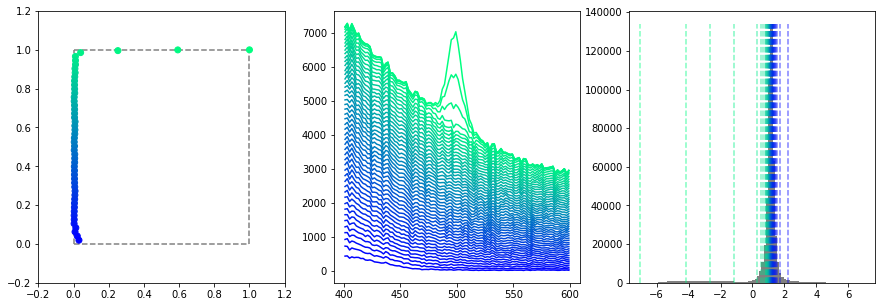

In [11]:
import importlib 
hm = importlib.reload(hm)

fig2, ax2 = plt.subplots(figsize = (15,5),ncols=3)

AUC2, cuts2 = hm.roc_curve_data(test_data.v0_ks_mass, p2,Npoints=50,ax_roc=ax2[0],ax_fits=ax2[1],ax_hist=ax2[2])

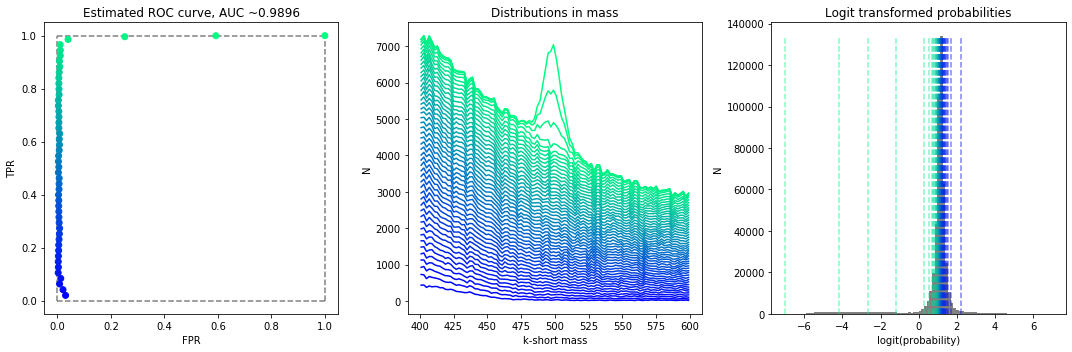

In [12]:
ax2[0].set(title=f'Estimated ROC curve, AUC ~{1+AUC2:.4f}', xlabel='FPR', ylabel='TPR',ylim=(-0.05,1.05),xlim=(-0.05,1.05))
ax2[1].set(title='Distributions in mass',xlabel='k-short mass', ylabel='N')
ax2[2].set(title='Logit transformed probabilities',xlabel='logit(probability)',ylabel='N')
fig2.tight_layout()
fig2
# fig2.savefig('figures/ML2_roc_data.pdf')

Cross validation, create pseudolabels for test data with 1 ML and draw roc curve with the other:

Firstly investigate amount of signal and background in test data

Completed fit with Chi2: 95.2, p-val: 0.361 and the total amount of signal 23149 +/- 293, background: 456362


Text(0.5, 1.0, 'signal: 23149$\\pm$293, background: 456361')

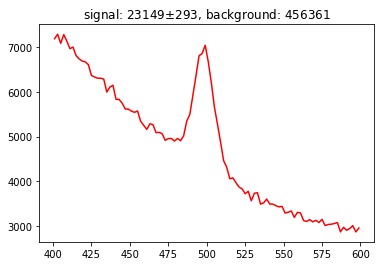

In [13]:
fig, ax = plt.subplots()
N_sig,N_bkgr,e_sig, M = hm.double_gauss_fit(test_data.v0_ks_mass,ax=ax,bins=100)
ax.set_title(f'signal: {N_sig:.0f}$\pm${e_sig:.0f}, background: {N_bkgr:.0f}')


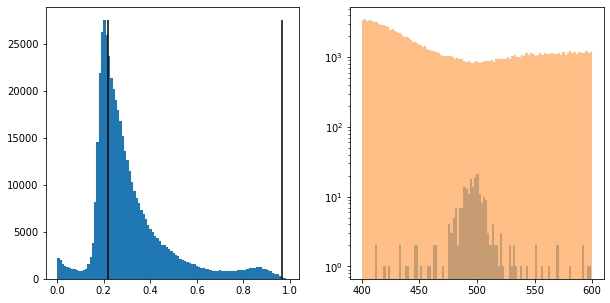

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

def test_labels(cla,features,sig_q=0.1,bkgr_q=0.3,bins=100):
    p = cla.predict_proba(test_data[features])[:,1]
    quantiles = np.quantile(p,(bkgr_q,1-sig_q))
    fig, ax = plt.subplots(figsize=(10,5),ncols=2)
    vals, _, _ = ax[0].hist(p,bins=bins)
    ax[0].vlines(quantiles,0,max(vals))
    
    ax[1].hist(test_data.v0_ks_mass[p>=quantiles[1]],bins=bins,alpha=0.5)
    ax[1].hist(test_data.v0_ks_mass[p<=quantiles[0]],bins=bins,alpha=0.5)
    ax[1].set_yscale('log')

    mask_sig = (p>=quantiles[1])
    mask_bkgr = (p<=quantiles[0])
    labels = np.zeros(len(p))*np.nan
    labels[mask_sig] = 1
    labels[mask_bkgr] = 0
    
    return mask_sig + mask_bkgr, labels
    
mask1, label1 = test_labels(cla1,ML1,sig_q=0.0005,bkgr_q=0.3)

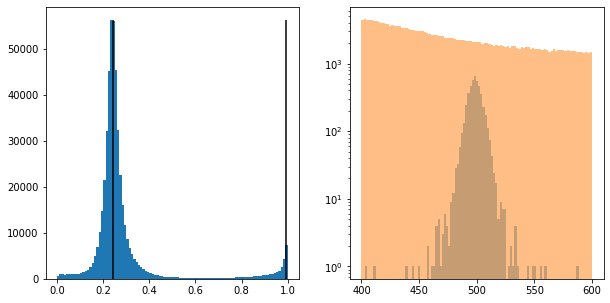

In [15]:
mask2, label2 = test_labels(cla2,ML2,sig_q=0.01,bkgr_q=0.5)

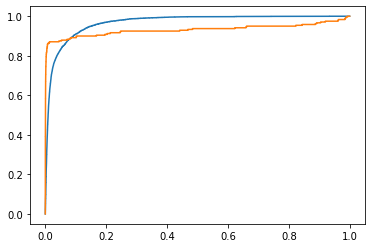

In [16]:
fig, ax = plt.subplots()

fpr1, tpr1, threshold1 = roc_curve(label2[mask2], 1-p1[mask2])
ax.plot(fpr1,tpr1)

fpr2, tpr2, threshold2 = roc_curve(label1[mask1], 1-p2[mask1])
ax.plot(fpr2,tpr2)

Now consider training in MC and test in data:

Firstly investigate validity of reweight

In [71]:
N = 6e5

path = "data/data15_13TeV.00267358.physics_MinBias.30062015_v0_per_0.root"
file = uproot.open(path)
data = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2, entrystop = N)

data = data.loc[(data.v0_ks_mass > 400) & (data.v0_ks_mass < 600)]
train_split_data = len(data)//3
# train_test_slice = int(len(data)*0.8)
# train_data = data[:train_test_slice]
# test_data = data[train_test_slice:]

path = "data/mc15_13TeV.361203.Pythia8_A2_MSTW2008LO_ND_minbias.30062015_v0_per_0.root"
file = uproot.open(path)
mc = file['tree'].pandas.df(["v0_ks_mass"]+ML1+ML2+['trueKs'], entrystop = N)

mc = mc.loc[(mc.v0_ks_mass > 400) & (mc.v0_ks_mass < 600)]

train_split_mc = len(mc)//3
# mc[:train_split_mc].trueKs.sum(),mc[train_split_mc:].trueKs.sum()

In [72]:
train_data = data[:train_split_data]
train_data_cla = data[train_split_data:2*train_split_data]
test_data = data[2*train_split_data:]

train_mc = mc[:train_split_mc]
train_mc_cla = mc[train_split_mc:2*train_split_mc]
test_mc = mc[2*train_split_mc:]

def remove_outliers(data,q1=0.05,q2=0.95):
    mask = np.ones(len(data),dtype=bool)
    for col in data.columns:
        mask *= data[col].between(data[col].quantile(q1),data[col].quantile(q2)).to_numpy()
    return mask

In [73]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from hep_ml.reweight import GBReweighter

# scaler_mc = RobustScaler(quantile_range=(0,100))
# scaler_data = RobustScaler(quantile_range=(0,100))

scaler_mc = MinMaxScaler()
scaler_data = MinMaxScaler()

scaled_train_data = pd.DataFrame(scaler_data.fit_transform(train_data[ML1+ML2][remove_outliers(train_data[ML1+ML2])]),columns=ML1+ML2)
scaled_train_mc = pd.DataFrame(scaler_mc.fit_transform(train_mc[ML1+ML2][remove_outliers(train_mc[ML1+ML2])]),columns=ML1+ML2)

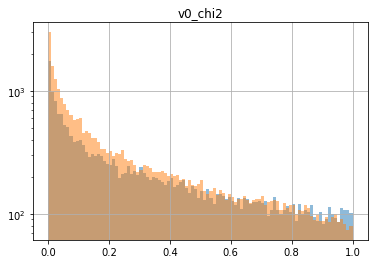

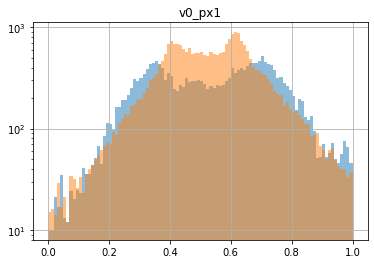

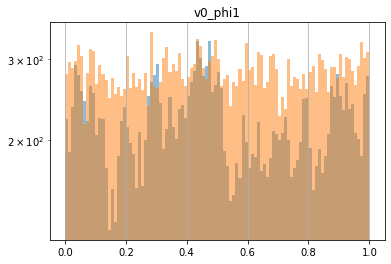

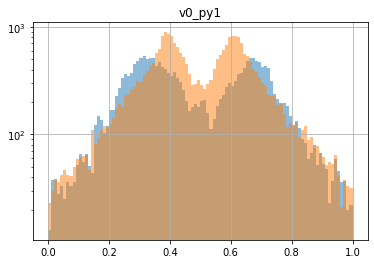

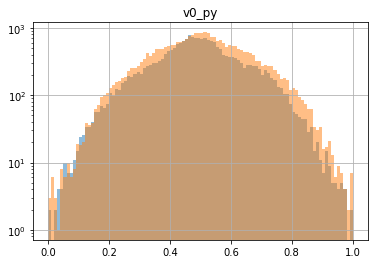

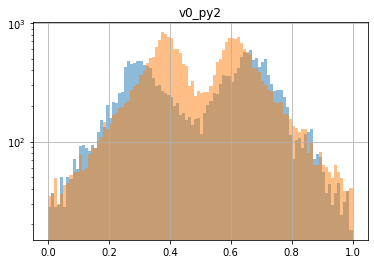

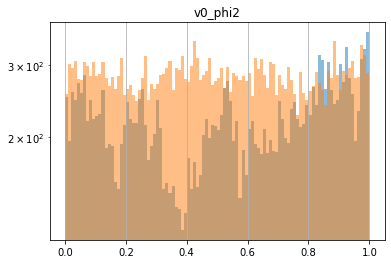

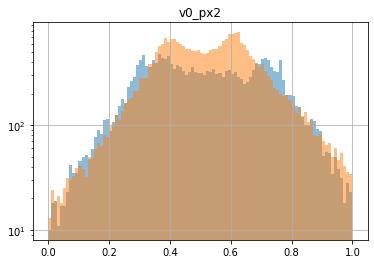

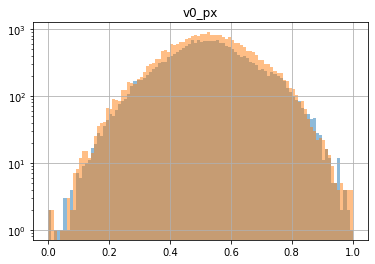

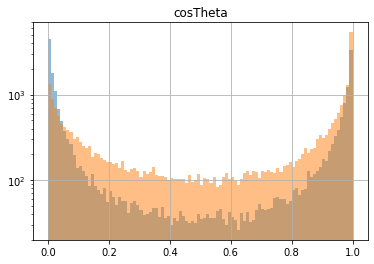

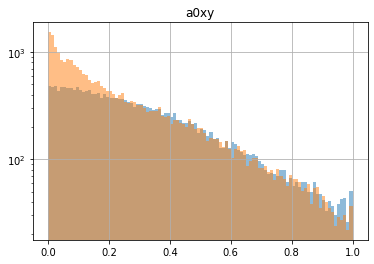

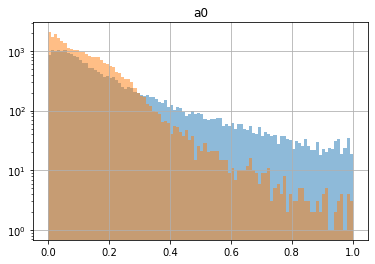

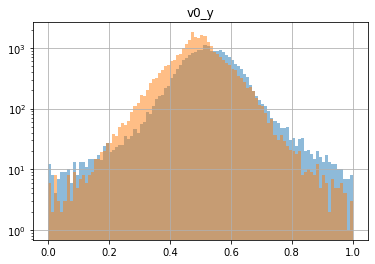

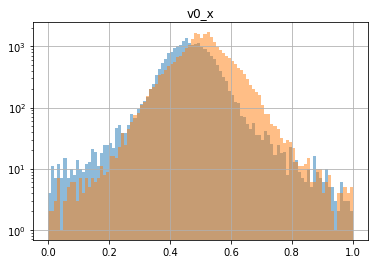

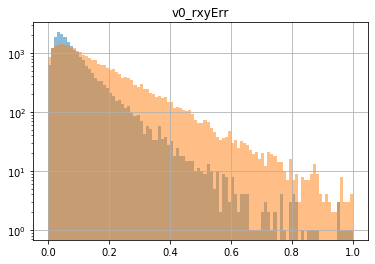

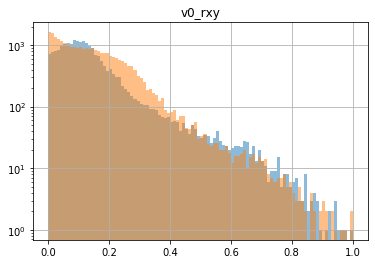

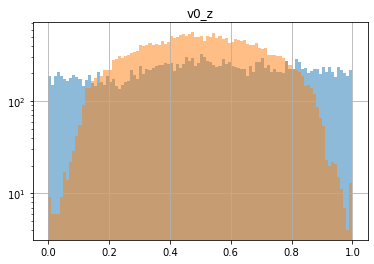

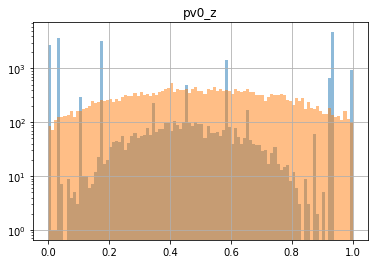

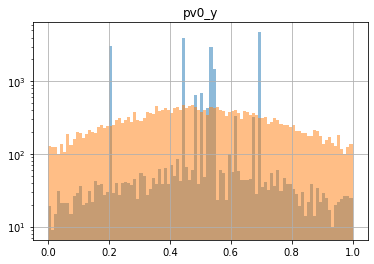

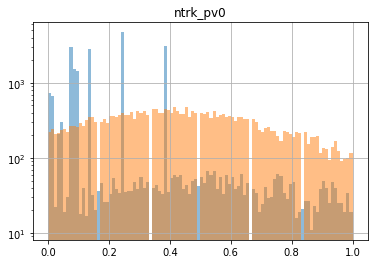

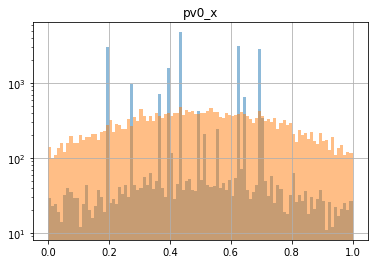

In [74]:
for feat in ML1+ML2:
    scaled_train_data[feat].hist(bins=100,alpha=0.5);
    scaled_train_mc[feat].hist(bins=100,alpha=0.5);
    plt.yscale('log')
    plt.title(feat)
    plt.show()

In [76]:
def scale_transform(scaler,data):
    return pd.DataFrame(scaler.transform(data),columns=data.columns)

scaled_train_data_cla = scale_transform(scaler_data,train_data_cla[ML1+ML2])
scaled_train_mc_cla = scale_transform(scaler_mc,train_mc_cla[ML1+ML2])

scaled_test_data = scale_transform(scaler_data,test_data[ML1+ML2])
scaled_test_mc = scale_transform(scaler_mc,test_mc[ML1+ML2])

In [77]:
cla = xgb.XGBClassifier()

cla.fit(X=pd.concat([scaled_train_data_cla,scaled_train_mc_cla]),
       y=np.append(np.zeros(len(scaled_train_data_cla)),np.ones(len(scaled_train_mc_cla))))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

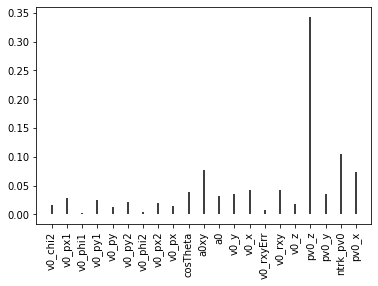

In [78]:
fig, ax = plt.subplots()
ax.vlines(range(len(ML1+ML2)),0,cla.feature_importances_)
ax.set_xticks(range(len(ML1+ML2)))
ax.set_xticklabels(ML1+ML2,rotation='vertical');

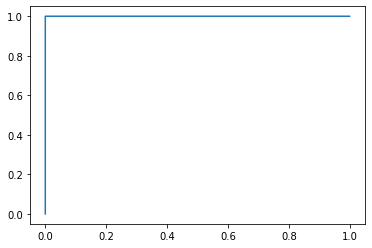

In [40]:
# fig, ax = plt.subplots()
# p = cla.predict_proba(pd.concat([scaled_train_data,scaled_train_mc]))[:,1]
# fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_train_data)),np.ones(len(scaled_train_mc))),p)

# ax.plot(fpr,tpr)

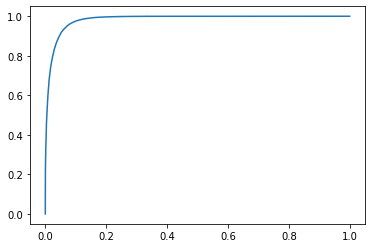

In [79]:
p = cla.predict_proba(pd.concat([scaled_test_data,scaled_test_mc]))[:,1]
fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_test_data)),np.ones(len(scaled_test_mc))),p)

fig, ax = plt.subplots()
ax.plot(fpr,tpr)

In [80]:
reweighter = GBReweighter()
reweighter.fit(original=scaled_train_mc, target=scaled_train_data)

GBReweighter(gb_args={}, learning_rate=0.2, loss_regularization=5.0,
             max_depth=3, min_samples_leaf=200, n_estimators=40)

In [95]:
mc_weights = reweighter.predict_weights(scaled_train_mc_cla)

In [111]:
cla_reweight = xgb.XGBClassifier()

mask = mc_weights < np.quantile(mc_weights,(0.9999))

cla_reweight.fit(X=pd.concat([scaled_train_data_cla,scaled_train_mc_cla[mask]]),
                 y=np.append(np.zeros(len(scaled_train_data_cla)),np.ones(len(scaled_train_mc_cla[mask]))),
                sample_weight = np.append(np.ones(len(scaled_train_data_cla)),mc_weights[mask]))

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

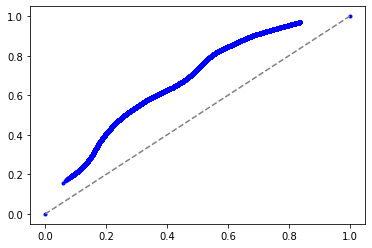

In [113]:
p_reweight = cla_reweight.predict_proba(pd.concat([scaled_test_data,scaled_test_mc]))[:,1]
fpr, tpr, t = roc_curve(np.append(np.zeros(len(scaled_test_data)),np.ones(len(scaled_test_mc))),p_reweight)

fig, ax = plt.subplots()
ax.plot(fpr,tpr,'b.')
ax.plot([0,1],[0,1],c='grey',linestyle='--')

In [88]:
p_reweight

array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)